# SVM
 * 最流行实现：序列最小化(Sequential Minimal Optimization, SMO)算法
 * 将SVM扩展到更多数据集上：核函数(kernel)
 * 通过SVM提高手写数字识别效果
 * Warning:SVM本身是一个二类分类器，对多类问题应用SVM需要对代码做一些修改

## 最流行实现：序列最小化(Sequential Minimal Optimization, SMO)算法
 * __一种求解支持向量机二次规划的算法。__
 * 一旦求出了所有的alpha，那么分隔超平面就可以通过这些alpha来表达。这一结论十分直接， SVM中的主要工作就是求解这些alpha。(P112 6.2.1最后)

### 基于最大间隔分割数据
 * 线性可分（linearly separable）数据
 * 我们希望找到离分隔__超平面__最近的点，确保它们离分隔面的距离尽可能远。这里点到分隔面的距离被称为间隔①（margin）。
 * 支持向量（support vector）就是离分隔超平面最近的那些点。接下来要试着最大化支持向量到分隔面的距离，需要找到此问题的优化求解方法。

### 寻找最大间隔
 * 这里的最大间隔指的是 支持向量 到分割面(即超平面)的距离
 * 计算 点 A 到 分 隔 超 平 面 的 距 离 ， 就 必 须 给 出 点 到 分 隔 面 的 法 线 或 垂 线 的 长 度 ， 该 值 为|wTA+b|/||w||。

#### 分类器求解的优化问题
 * label * (wTx+b)被称为点到分隔面的函数间隔;
 * 点到分隔面的__几何__间隔
 * 拉格朗日乘子(法)
 * SVM中的主要工作就是求解这些alpha
 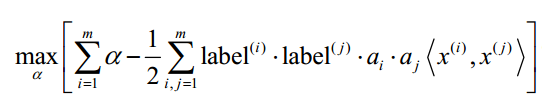
 * 上图是优化目标函数，尖括号表示 x( ) i 和 x( ) j 两个向量的内积。
 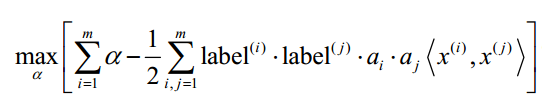
 * 上图是约束条件，这里的常数C用于控制“最大化间隔”和“保证大部分点的函数间隔小于1.0”这两个目标的权重。在优化算法的实现代码中，常数C是一个参数，因此我们就可以通过调节该参数得到不同的结果。一旦求出了所有的alpha，那么分隔超平面就可以通过这些alpha来表达。这一结论十分直接， SVM中的主要工作就是求解这些alpha。

#### SVM应用的一般框架

### SMO 高效优化算法
 * 简化版（易理解）
 * 完整版（效率高，速度快）

#### 简化版 SMO 算法
 * 处理小规模数据集

In [1]:
from numpy import *
from time import sleep

In [2]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

# 辅助函数，用于在某个区间范围内随机选择一个整数
# i 是第一个alpha的下标，m 是所有alpha的数目
def selectJrand(i, m):
    j = i
    while (j==i):
        j = int(random.uniform(0, m))
    return j

# 辅助函数，用于在数值太大时对其进行调整
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [4]:
dataArr, labelArr = loadDataSet('testSet.txt')
labelArr

[-1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0]

In [43]:
# 简化版 SMO 算法
# 输入的五个参数分别代表：数据集，类别标签，常数C，容错率和退出前最大的循环次数
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn)
    labelMat = mat(classLabels).transpose()
    b = 0
    m, n = shape(dataMatrix)
    alphas = mat(zeros((m, 1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(multiply(alphas, labelMat).T*\
                       (dataMatrix*dataMatrix[i, :].T)) + b
            Ei = fXi - float(labelMat[i])
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or \
                ((labelMat[i]*Ei > toler) and \
                (alphas[i] > 0)):
                j = selectJrand(i, m)
                fXj = float(multiply(alphas, labelMat).T*\
                           (dataMatrix*dataMatrix[j, :].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy();
                alphaJold = alphas[j].copy();
                #
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H :
                    print 'L==H'
                    continue
                eta = 2.0 * dataMatrix[i, :]*dataMatrix[j, :].T - \
                      dataMatrix[i, :]*dataMatrix[i, :].T - \
                      dataMatrix[j, :]*dataMatrix[j, :].T
                if eta >= 0:
                    print 'eta>=0'
                    continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print 'j not moving enough'
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*\
                          (alphaJold - alphas[j])
                b1 = b - Ei - labelMat[i]*(alphas[i] - alphaIold)*\
                    dataMatrix[i, :]*dataMatrix[i, :].T - \
                    labelMat[j]*(alphas[j] - alphaJold)*\
                    dataMatrix[i, :]*dataMatrix[j, :].T
                b2 = b - Ej - labelMat[i]*(alphas[i]-alphaIold)*\
                    dataMatrix[i, :]*dataMatrix[j, :].T - \
                    labelMat[j]*(alphas[j]-alphaJold)*\
                    dataMatrix[j, :]*dataMatrix[j, :].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print 'iter: %d i: %d, pairs changed %d' % (iter, i, alphaPairsChanged)
        if (alphaPairsChanged == 0):
            iter += 1
        else:
            iter = 0
        print 'iteration number: %d' % iter
    return b, alphas

In [44]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

L==H
L==H
iter: 0 i: 2, pairs changed 1
j not moving enough
j not moving enough
L==H
iter: 0 i: 17, pairs changed 2
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
iteration number: 0
iter: 0 i: 2, pairs changed 1
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
iter: 0 i: 26, pairs changed 2
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
iter: 0 i: 76, pairs changed 3
j not moving enough
iteration number: 0
iter: 0 i: 2, pairs changed 1
L==H
j not moving enough
j not moving enough
iter: 0 i: 13, pairs changed 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iter: 0 i: 55, pairs changed 3
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not

j not moving enough
j not moving enough
j not moving enough
iter: 1 i: 54, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 3 i: 55, pairs changed 1
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enoug

iteration number: 26
j not moving enough
j not moving enough
j not moving enough
iteration number: 27
j not moving enough
j not moving enough
j not moving enough
iteration number: 28
j not moving enough
j not moving enough
j not moving enough
iteration number: 29
j not moving enough
j not moving enough
j not moving enough
iteration number: 30
j not moving enough
j not moving enough
j not moving enough
iteration number: 31
j not moving enough
j not moving enough
j not moving enough
iteration number: 32
j not moving enough
j not moving enough
j not moving enough
iteration number: 33
j not moving enough
j not moving enough
j not moving enough
iteration number: 34
j not moving enough
j not moving enough
j not moving enough
iteration number: 35
j not moving enough
j not moving enough
j not moving enough
iteration number: 36
j not moving enough
j not moving enough
j not moving enough
iteration number: 37
j not moving enough
j not moving enough
j not moving enough
iteration number: 38
j not m

In [45]:
b

matrix([[-3.76440243]])

In [46]:
# alphas[alphas>0]命令是数组过滤（array filtering）的一个实例，而且它只对NumPy类型有用，却并不适用于Python中的正则表（regular list）。
alphas[alphas>0]

matrix([[0.02626174, 0.25028778, 0.06881097, 0.15946895, 0.18589154]])

In [47]:
shape(alphas[alphas>0])

(1L, 5L)

In [48]:
for i in range(100):
    if alphas[i] > 0.0:
        print dataArr[i], labelArr[i]

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[2.893743, -1.643468] -1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


#### 完整版 Platt SMO 算法
 * 在这两个版本中，实现alpha的更改和代数运算的优化环节一模一样。在优化过程中，唯一的不同就是选择alpha的方式。
 * Platt SMO算法是通过一个外循环来选择第一个alpha值的，并且其选择过程会在两种方式之间进行交替：一种方式是在所有数据集上进行单遍扫描，另一种方式则是在非边界alpha中实现单遍扫描。而所谓非边界alpha指的就是那些不等于边界0或C的alpha值。对整个数据集的扫描相当容易，而实现非边界alpha值的扫描时，首先需要建立这些alpha值的列表，然后再对这个表进行遍历。同时，该步骤会跳过那些已知的不会改变的alpha值。
 * 在选择第一个alpha值后，算法会通过一个内循环来选择第二个alpha值。在优化过程中，会通过最大化步长的方式来获得第二个alpha值。在简化版SMO算法中，我们会在选择j之后计算错误率Ej。但在这里，我们会建立一个全局的缓存用于保存误差值，并从中选择使得步长或者说Ei-Ej最大的alpha值。

In [3]:
# 用来清理上一节的代码的数据结构，通过构造一个类来实现，可以保存所有重要值，这样可以省掉手工输入的麻烦
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2)))
        # 为核函数 kernel 新增的代码段
        self.K = mat(zeros((self.m, self.m)))
        for i in range(self.m):
            # kernelTrans() 是核转换函数
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], kTup)

# 辅助函数，能够计算E值并返回
def calcEk(oS, k):
    # 为使用核函数做出了修改
#     fXk = float(multiply(oS.alphas, oS.labelMat).T*\
#                (oS.X*oS.X[k, :].T)) + oS.b
    fXk = float(multiply(oS.alphas, oS.labelMat).T*oS.K[:, k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

# 辅助函数，选择第二个alpha或者说内循环的alpha值
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

# 计算误差值并存入缓存当中。在对alpha值进行优化之后会用到这个值
def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

In [4]:
# 用于寻找决策边界的优化例程
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or \
        ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i]  != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print 'L == H'
            return 0
        # 为使用核函数做出了修改
        # eta = 2.0*oS.X[i, :]*oS.X[j, :].T - oS.X[i, :]*oS.X[i, :].T - \
        # oS.X[j, :]*oS.X[j, :].T
        eta = 2.0*oS.K[i, j] - oS.K[i, i] - oS.K[j, j]
        if eta >= 0:
            print 'eta >= 0'
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print 'j not monving enough'
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*\
                        (alphaJold - oS.alphas[j])
        updateEk(oS, i)
        # 为使用核函数做出了修改
#         b1 = oS.b - Ei - oS.labelMat[i]*(oS.alphas[i] - alphaIold)*\
#             oS.X[i, :]*oS.X[i, :].T - oS.labelMat[j]*\
#             (oS.alphas[j] - alphaJold)*oS.X[i, :]*oS.X[j, :].T
#         b2 = oS.b - Ej - oS.labelMat[i]*(oS.alphas[i] - alphaIold)*\
#             oS.X[i, :]*oS.X[j, :].T - oS.labelMat[j]*\
#             (oS.alphas[j] - alphaJold)*oS.X[j, :]*oS.X[j, :].T
        b1 = oS.b - Ei - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i, i]-\
                            oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i, j]
        b2 = oS.b - Ej - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i, j]-\
                            oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j, j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 <oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0

In [5]:
# Platt SMO 的外循环代码
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
                print 'fullSet, iter: %d i: %d, pairs changed %d' %\
                    (iter, i, alphaPairsChanged)
            iter += 1
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print 'non-bound, iter: %d i: %d, pairs changed %d' % \
                    (iter, i, alphaPairsChanged)
            iter += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged == 0):
            entireSet = True
        print 'iteration number: %d' % iter
    return oS.b, oS.alphas

In [27]:
dataArr, labelArr = loadDataSet('testSet.txt')
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001,40)

L == H
fullSet, iter: 0 i: 0, pairs changed 0
L == H
fullSet, iter: 0 i: 1, pairs changed 0
fullSet, iter: 0 i: 2, pairs changed 1
L == H
fullSet, iter: 0 i: 3, pairs changed 1
fullSet, iter: 0 i: 4, pairs changed 2
fullSet, iter: 0 i: 5, pairs changed 2
fullSet, iter: 0 i: 6, pairs changed 2
j not monving enough
fullSet, iter: 0 i: 7, pairs changed 2
L == H
fullSet, iter: 0 i: 8, pairs changed 2
fullSet, iter: 0 i: 9, pairs changed 2
L == H
fullSet, iter: 0 i: 10, pairs changed 2
L == H
fullSet, iter: 0 i: 11, pairs changed 2
L == H
fullSet, iter: 0 i: 12, pairs changed 2
fullSet, iter: 0 i: 13, pairs changed 2
L == H
fullSet, iter: 0 i: 14, pairs changed 2
fullSet, iter: 0 i: 15, pairs changed 2
fullSet, iter: 0 i: 16, pairs changed 2
L == H
fullSet, iter: 0 i: 17, pairs changed 2
fullSet, iter: 0 i: 18, pairs changed 3
fullSet, iter: 0 i: 19, pairs changed 3
fullSet, iter: 0 i: 20, pairs changed 3
fullSet, iter: 0 i: 21, pairs changed 3
j not monving enough
fullSet, iter: 0 i: 22, p

In [30]:
# 基于alpha值得到超平面，这也包括了w的计算
def calcWs(alphas, dataArr, classLabels):
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i], X[i, :].T)
    return w

In [31]:
ws = calcWs(alphas, dataArr, labelArr)
ws

array([[ 0.65307162],
       [-0.17196128]])

In [32]:
dataMat = mat(dataArr)
dataMat[0]*mat(ws) + b
# 如果该值大于0，那么其属于1类；如果该值小于0，那么则属于1类

matrix([[-0.92555695]])

In [33]:
# 对于数据点0，应该得到的类别标签是1，可以通过如下的命令来确认分类结果的正确性：
labelArr[0]

-1.0

## 在复杂数据上应用核函数(kernel)
 * __以说明类别区域形状不同情况下的数据集分隔问题__
 * 最流行的核函数: 径向基函数（radialbias function）

### 利用核函数将数据映射到高维空间
 * 我们或许可以对圆中的数据进行某种形式的转换，从而得到某些新的变量来表示数据。在这种表示情况下，我们就更容易得到大于0或者小于0的测试结果。在这个例子中，我们将数据从一个特征空间转换到另一个特征空间。在新空间下，我们可以很容易利用已有的工具对数据进行处理。数学家们喜欢将这个过程称之为从一个特征空间到另一个特征空间的映射。在通常情况下，这种映射会将低维特征空间映射到高维空间。
 * __这种从某个特征空间到另一个特征空间的映射是通过核函数来实现的。__
 * __经过空间转换之后，我们可以在高维空间中解决线性问题，这也就等价于在低维空间中解决非线性问题。__
 * 内积（inner product，也称点积）:向量的内积指的是两个向量相乘，之后得到单个标量或者数值。
 * **将内积替换成核函数**的方式被称为核技巧（kernel trick）或者核“变电”（kernel substation）

### 径向基函数（radialbias function）
 * 具体公式：
 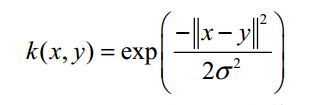
 __其中，sigmoid 是用户定义的用于确定到达率（reach）或者说函数值跌落到0的速度参数__

In [6]:
# 核转换函数
def kernelTrans(X, A, kTup):
    m, n = shape(X)
    K = mat(zeros((m, 1)))
    if kTup[0] == 'lin':
        K = X * A.T
    elif kTup[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow * deltaRow.T
        K = exp(K/(-1*kTup[1]**2))
    else:
        raise NameError('Houseton We Have a Problem -- \
            That Kernel is not recongnized')
    return K

### 在测试中使用核函数
 * 核方法或者说核技巧会将数据（有时是非线性数据）从一个低维空间映射到一个高维空间，可以将一个在低维空间中的非线性问题转换成高维空间下的线性问题来求解。核方法不止在SVM中适用，还可以用于其他算法中。而其中的径向基函数是一个常用的度量两个向量距离的核函数。

In [7]:
# 利用核函数进行分类的径向基测试函数
def testRbf(k1 = 1.3):
    # 第一个测试集，用来训练
    dataArr, labelArr = loadDataSet('testSetRBF.txt')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1))
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]
    # 构建支持向量矩阵
    sVs = dataMat[svInd]
    labelSV = labelMat[svInd]
    print 'there are %d Support Vectors' % shape(sVs)[0]
    m, n = shape(dataMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :], ('rbf', k1))
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]):
            errorCount += 1
    print 'the training error rate is: %f' % (float(errorCount)/m)
    
    # 第二个测试集
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    m, n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], ('rbf', k1))
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]):
            errorCount += 1
    print 'the test error rate is: %f' % (float(errorCount)/m)

    
## 从官方文档里复制的一段，这个结果就是不稳定的
# def testRbf(k1=1.3):
#     dataArr,labelArr = loadDataSet('testSetRBF.txt')
#     b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
#     datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
#     svInd=nonzero(alphas.A>0)[0]
#     sVs=datMat[svInd] #get matrix of only support vectors
#     labelSV = labelMat[svInd];
#     print "there are %d Support Vectors" % shape(sVs)[0]
#     m,n = shape(datMat)
#     errorCount = 0
#     for i in range(m):
#         kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
#         predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
#         if sign(predict)!=sign(labelArr[i]): errorCount += 1
#     print "the training error rate is: %f" % (float(errorCount)/m)
#     dataArr,labelArr = loadDataSet('testSetRBF2.txt')
#     errorCount = 0
#     datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
#     m,n = shape(datMat)
#     for i in range(m):
#         kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
#         predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
#         if sign(predict)!=sign(labelArr[i]): errorCount += 1    
#     print "the test error rate is: %f" % (float(errorCount)/m)    

In [8]:
testRbf()

L == H
fullSet, iter: 0 i: 0, pairs changed 0
fullSet, iter: 0 i: 1, pairs changed 1
fullSet, iter: 0 i: 2, pairs changed 2
fullSet, iter: 0 i: 3, pairs changed 3
fullSet, iter: 0 i: 4, pairs changed 3
fullSet, iter: 0 i: 5, pairs changed 4
fullSet, iter: 0 i: 6, pairs changed 5
fullSet, iter: 0 i: 7, pairs changed 5
fullSet, iter: 0 i: 8, pairs changed 6
fullSet, iter: 0 i: 9, pairs changed 6
fullSet, iter: 0 i: 10, pairs changed 7
fullSet, iter: 0 i: 11, pairs changed 8
j not monving enough
fullSet, iter: 0 i: 12, pairs changed 8
fullSet, iter: 0 i: 13, pairs changed 9
fullSet, iter: 0 i: 14, pairs changed 10
fullSet, iter: 0 i: 15, pairs changed 11
fullSet, iter: 0 i: 16, pairs changed 12
fullSet, iter: 0 i: 17, pairs changed 12
fullSet, iter: 0 i: 18, pairs changed 13
fullSet, iter: 0 i: 19, pairs changed 14
fullSet, iter: 0 i: 20, pairs changed 14
fullSet, iter: 0 i: 21, pairs changed 15
fullSet, iter: 0 i: 22, pairs changed 15
fullSet, iter: 0 i: 23, pairs changed 15
fullSet, ite

L == H
fullSet, iter: 4 i: 96, pairs changed 0
fullSet, iter: 4 i: 97, pairs changed 0
fullSet, iter: 4 i: 98, pairs changed 0
fullSet, iter: 4 i: 99, pairs changed 0
iteration number: 5
there are 29 Support Vectors
the training error rate is: 0.130000
the test error rate is: 0.150000


__支持向量机是一个二类分类器。当用其解决多类问题时，则需要额外的方法对其进行扩展。SVM的效果也对优化参数和所用核函数中的参数敏感。__